# XGBoost with Hyperopt

Based upon: 

https://medium.com/@justin.wesley.johns/precision-ml-engineering-with-xgboost-hyperopt-attaining-98-11-accuracy-on-mnist-d737b7ef1081

and

https://github.com/flyinacres/kaggle/blob/main/abalone-submission-03.ipynb


### Get Abalone Data 

have to add the dataset for this to work

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statistics as st
import warnings
import matplotlib.pyplot as plt 

warnings.filterwarnings('ignore')

In [2]:
# SPLITTING THE DATASET
target_path = '/kaggle/input/abalone/train.csv'
submission_path = '/kaggle/input/abalone/test.csv'

target = pd.read_csv(target_path)
submission = pd.read_csv(submission_path)

In [3]:
# One-hot encode 'Sex'
target = pd.get_dummies(target, columns=['Sex'], drop_first=True)
submission = pd.get_dummies(submission, columns=['Sex'], drop_first=True)

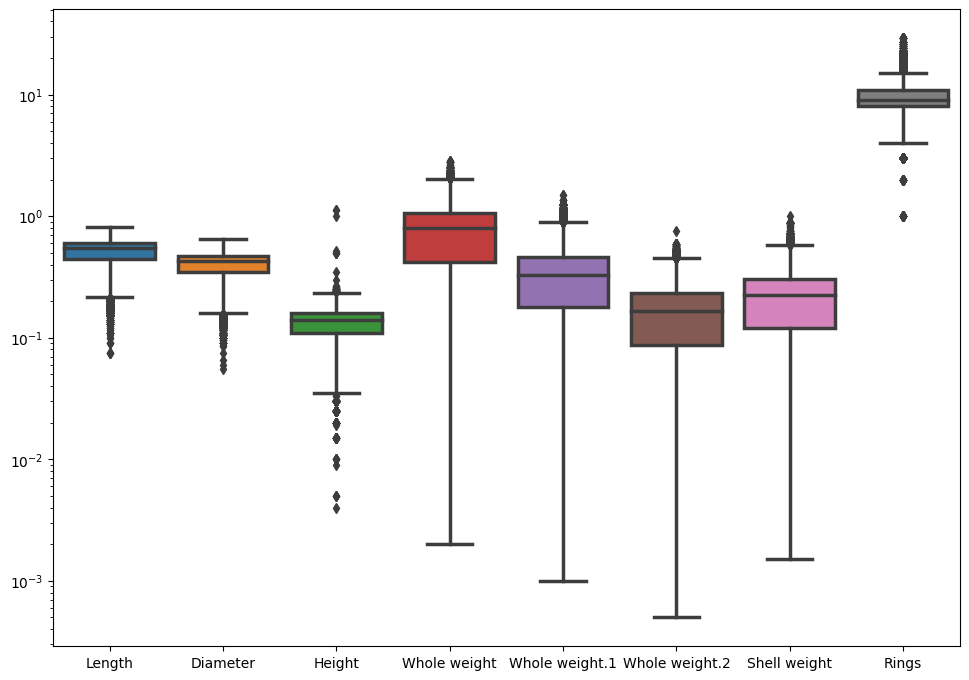

In [4]:
import seaborn as sns

a4_dims = (11.7, 8.27)
# drop is not destructive unless the inplace argument is used
# Note that the axis is required or it thinks you want to drop a row
no_id_target = target.drop(['id', 'Sex_I', 'Sex_M'], axis=1)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(data=no_id_target,linewidth=2.5,ax=ax)
g.set_yscale("log")

In [5]:
x = target.drop('Rings', axis = 1)
y = target['Rings']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Bring in the evaluation code I have used throughout this work

In [7]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [8]:
def identify_negatives(predictions):
    n = [num for num in predictions if num < 0]
    print(n)

In [9]:
def ceil_predictions(predictions):
    return [0.0001 if num < 0 else num for num in predictions]

In [10]:
# Need to ensure that results don't contain negative numbers or 0, or log will not work.
#n = [0.0001 if num < 0 else num for num in models[2]['predictions']]
#print(n)

In [11]:
from sklearn.metrics import r2_score

def evaluate_model(true, predicted):
    # mae = mean_absolute_error(true, predicted)
    # mse = mean_squared_error(true, predicted)
    # rmse = np.sqrt(mean_squared_error(true, predicted))
    predicted = ceil_predictions(predicted)
    r2_square = r2_score(true, predicted)
    rmsle = root_mean_squared_log_error(true, predicted)
    return r2_square,rmsle 

## XGBoost and HyperOpt

TODO:

* change XGB classifier to regressor
  https://xgboost.readthedocs.io/en/stable/python/python_api.html
* Change params to match the regressor params (likely different than the classifier ones)
* Change my 'ADABoost' code to use the XGB Regressor with best params
* profit!

In [12]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.preprocessing import LabelEncoder
import numpy as np

### First, without hyperopt

Make sure I have the basics of XGBRegressor...

In [13]:
xgb1 = xgb.XGBRegressor(n_estimators=100,
                    learning_rate = .1,
                    max_depth = 6,
                    random_state=42,
                    n_jobs = -1,
                    early_stopping_rounds=10)

In [14]:
xgb1.fit(
    x_train, 
    y_train, 
    eval_metric="rmse",
    eval_set=[(x_test, y_test)],
    verbose=True )

[0]	validation_0-rmse:2.98598
[1]	validation_0-rmse:2.82014
[2]	validation_0-rmse:2.67677
[3]	validation_0-rmse:2.55448
[4]	validation_0-rmse:2.44895
[5]	validation_0-rmse:2.35974
[6]	validation_0-rmse:2.28408
[7]	validation_0-rmse:2.21873
[8]	validation_0-rmse:2.16431
[9]	validation_0-rmse:2.11835
[10]	validation_0-rmse:2.07928
[11]	validation_0-rmse:2.04667
[12]	validation_0-rmse:2.01948
[13]	validation_0-rmse:1.99553
[14]	validation_0-rmse:1.97551
[15]	validation_0-rmse:1.95809
[16]	validation_0-rmse:1.94341
[17]	validation_0-rmse:1.93092
[18]	validation_0-rmse:1.92114
[19]	validation_0-rmse:1.91225
[20]	validation_0-rmse:1.90555
[21]	validation_0-rmse:1.89889
[22]	validation_0-rmse:1.89422
[23]	validation_0-rmse:1.88976
[24]	validation_0-rmse:1.88540
[25]	validation_0-rmse:1.88188
[26]	validation_0-rmse:1.87793
[27]	validation_0-rmse:1.87546
[28]	validation_0-rmse:1.87325
[29]	validation_0-rmse:1.87133
[30]	validation_0-rmse:1.86849
[31]	validation_0-rmse:1.86687
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
xgb1.score(x_test,y_test)

0.6633260055397581

In [16]:
pred = xgb1.predict(x_test)
print(evaluate_model(y_test, pred))

(0.6633260055397581, 0.15134385670646433)


# Untuned results

For abalone 3 I had 0.177 without Adaboost, 0.158 with Adaboost.
This first version of XGBoost is 0.1513, so a little better already!


### Now with hyperopt

Note that these sample params are from an example of XGBRegressor.  I may need them to tune the space.

https://www.kaggle.com/code/subhamkapoor360/xgbregressor

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bytree=1, early_stopping_rounds=10, gamma=0,
           learning_rate=0.1, max_delta_step=0, max_depth=6,
           min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
           nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
           reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
           subsample=1)

In [17]:
# Define the hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.1),
    'reg_lambda': hp.uniform('reg_lambda', 0.5, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 600, 50),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'tree_method': 'gpu_hist'  # Use GPU
}


In [18]:
# Can't use accuracy as that is for measuring classification, not regression
#from sklearn.metrics import accuracy_score

# Define the objective function
def objective(space):
    clf = xgb.XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        subsample=space['subsample'],
        learning_rate=space['learning_rate'],
        #tree_method=space['tree_method'],
        #use_label_encoder=False,  # Avoid the deprecation warning
        #eval_metric='mlogloss'
    )
    evaluation = [(x_train, y_train), (x_test, y_test)]
        
    clf.fit(x_train, y_train,
                eval_set=evaluation, verbose=True)
        
    pred = clf.predict(x_test)
    accuracy = r2_score(y_test, pred)
    print(f"SCORE: {accuracy}")

    return {'loss': -accuracy, 'status': STATUS_OK}

Caution, slow code!!!

In [19]:
%%time


# Run the optimization
trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=20,
                        trials=trials)


[0]	validation_0-rmse:3.00180	validation_1-rmse:3.00517
[1]	validation_0-rmse:2.84724	validation_1-rmse:2.85306
[2]	validation_0-rmse:2.72162	validation_1-rmse:2.73071
[3]	validation_0-rmse:2.60709	validation_1-rmse:2.61946
[4]	validation_0-rmse:2.49872	validation_1-rmse:2.51459
[5]	validation_0-rmse:2.40410	validation_1-rmse:2.42275
[6]	validation_0-rmse:2.31952	validation_1-rmse:2.34168
[7]	validation_0-rmse:2.24675	validation_1-rmse:2.27190
[8]	validation_0-rmse:2.18336	validation_1-rmse:2.21182
[9]	validation_0-rmse:2.13296	validation_1-rmse:2.16452
[10]	validation_0-rmse:2.08788	validation_1-rmse:2.12326
[11]	validation_0-rmse:2.04509	validation_1-rmse:2.08291
[12]	validation_0-rmse:2.00670	validation_1-rmse:2.04917
[13]	validation_0-rmse:1.97665	validation_1-rmse:2.02254
[14]	validation_0-rmse:1.94814	validation_1-rmse:1.99758
[15]	validation_0-rmse:1.92363	validation_1-rmse:1.97576
[16]	validation_0-rmse:1.90165	validation_1-rmse:1.95701
[17]	validation_0-rmse:1.88228	validation

In [20]:
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

The best hyperparameters are:  

{'colsample_bytree': 0.6803858244364771, 'gamma': 0.13740543805661887, 'learning_rate': 0.06119263748317788, 'max_depth': 5.0, 'n_estimators': 500.0, 'reg_alpha': 0.0868270901524108, 'reg_lambda': 1.3989390366915686, 'subsample': 0.6510886501185364}


### Best Params

{'colsample_bytree': 0.818472425697768, 'gamma': 0.20696681071563716, 'learning_rate': 0.054701682430341694, 'max_depth': 7.0, 'n_estimators': 500.0, 'reg_alpha': 0.05496673624692969, 'reg_lambda': 0.7587490847870214, 'subsample': 0.7490193046400793}

### Try using the 'best params'

In [21]:
# Again, params are not quite directly usable...
#xgb2 = xgb.XGBRegressor(**best_hyperparams)

xgb2 = xgb.XGBRegressor(**{'colsample_bytree': 0.818472425697768, 
                           'gamma': 0.20696681071563716, 
                           'learning_rate': 0.054701682430341694, 
                           'max_depth': 7, 
                           'n_estimators': 500, 
                           'reg_alpha': 0.05496673624692969, 
                           'reg_lambda': 0.7587490847870214, 
                           'subsample': 0.7490193046400793})

In [22]:
xgb2.fit(
    x_train, 
    y_train, 
    eval_metric="rmse",
    eval_set=[(x_test, y_test)],
    verbose=True )

[0]	validation_0-rmse:3.06895
[1]	validation_0-rmse:2.96987
[2]	validation_0-rmse:2.88661
[3]	validation_0-rmse:2.80571
[4]	validation_0-rmse:2.72552
[5]	validation_0-rmse:2.65199
[6]	validation_0-rmse:2.58314
[7]	validation_0-rmse:2.52023
[8]	validation_0-rmse:2.46168
[9]	validation_0-rmse:2.41244
[10]	validation_0-rmse:2.36866
[11]	validation_0-rmse:2.32312
[12]	validation_0-rmse:2.28161
[13]	validation_0-rmse:2.24703
[14]	validation_0-rmse:2.21173
[15]	validation_0-rmse:2.17987
[16]	validation_0-rmse:2.15053
[17]	validation_0-rmse:2.12390
[18]	validation_0-rmse:2.09945
[19]	validation_0-rmse:2.07947
[20]	validation_0-rmse:2.06132
[21]	validation_0-rmse:2.04218
[22]	validation_0-rmse:2.02510
[23]	validation_0-rmse:2.00949
[24]	validation_0-rmse:1.99510
[25]	validation_0-rmse:1.98169
[26]	validation_0-rmse:1.96933
[27]	validation_0-rmse:1.95999
[28]	validation_0-rmse:1.95020
[29]	validation_0-rmse:1.94119
[30]	validation_0-rmse:1.93368
[31]	validation_0-rmse:1.92672
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.818472425697768, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.20696681071563716,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.054701682430341694,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
xgb2.score(x_test,y_test)


0.6678008429608555

In [24]:
pred = xgb2.predict(x_test)
print(evaluate_model(y_test, pred))

(0.6678008429608555, 0.15043102742823455)


## Hyperopt tuned results

For abalone 3 I had 0.177 without Adaboost, 0.158 with Adaboost. The first version of XGBoost is 0.1513. After tuning with hyperopt it is down to 0.1504, so better still.

This is without any feature engineering.

And it is possible that I could tune the space and evaluation function to do a better job of picking the parameters--this could take a lot of experimentation!



## Submission Attempt

Grab the submission code from

https://github.com/flyinacres/kaggle/blob/main/abalone-submission-03.ipynb

and try to submit this version...

In [25]:
submission.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Sex_I,Sex_M
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,False,True
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,False,True
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,False,True
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,False,True
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,True,False


In [26]:
submission_pred = xgb2.predict(submission)

In [27]:
id_df = submission.id
pred_df = pd.DataFrame(submission_pred, columns=['Rings'])

final_df = pd.concat([id_df, pred_df], axis=1)

final_df.head()

,id,Rings
0,90615,9.754084
1,90616,9.632403
2,90617,10.341323
3,90618,10.530637
4,90619,7.922883


In [28]:
# Strange, cannot see the file saved with -04.  Only have the -03 version

final_df.to_csv('abalone-submission-04.csv', index=False)

### Scores from my submissions

0.16208 (initial)

0.15625 (Adaboost)

0.15076 (this one, xgboost with hyperopt)

0.14374 (all time leader)